In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from networkx.algorithms import bipartite
from random import shuffle
from sklearn.cluster import SpectralClustering

In [106]:
FILENAME = '/om2/user/annakoop/DiabetesPredictionModel/dataset_diabetes/diabetic_data.csv'
TEST_FRACTION = 0.1
NETWORK_SIZE = 5000
N_CLUSTERS = 2

In [154]:
def remove_duplicate_patients(data):
    data_dict = {}
    for row in data:
        if row[1] in data_dict:
            data_dict[row[1]].append(row)
        else:
            data_dict[row[1]] = [row]
    data_pruned = []
    for patient in data_dict:
        if len(data_dict[patient]) == 1:
            data_pruned.append(data_dict[patient][0])
        else:
            options = []
            for encounter in data_dict[patient]:
                if encounter[49] == '<30' or encounter[49] == '>30':
                    options.append(encounter)
            if len(options) == 0:
                options = data_dict[patient]
            ind = np.random.randint(0, len(options))
            data_pruned.append(options[ind])
    return data_pruned
def separate_test_train(data):
    shuffle(data)
    cutoff = int(len(data) * (1 - TEST_FRACTION))
    return data[:cutoff], data[cutoff:]
def make_network(data):
    adj = np.zeros((len(data), len(data)), dtype=np.int8)
    for x, row1 in enumerate(data):
        for y, row2 in enumerate(data[x + 1:]):
            # medications span indices 24 - 46
            for i in range(24, 47):
                if row1[i] == row2[i]:
                    adj[x, y + x + 1] += 1
                    adj[y + x + 1, x] += 1
                    if row1[i] != 'No':
                        adj[x, y + x + 1] += 3
                        adj[y + x + 1, x] += 3
        if x % 200 == 0:
            print(x)
    return adj
def analyze_clusters(data, labels):
    cluster_sizes = [0]*N_CLUSTERS
    readmission_frac = [0]*N_CLUSTERS
    meds_frac = [[0 for i in range(23)] for j in range(N_CLUSTERS)]
    admission_type = [[] for i in range(N_CLUSTERS)]
    for i, row in enumerate(data):
        c = labels[i]
        cluster_sizes[c] += 1
        admission_type[c].append(row[8])
        if row[49] == '<30' or row[49] == '>30':
            readmission_frac[c] += 1
        for m in range(24, 47):
            if row[m] != 'No':
                meds_frac[c][m - 24] += 1
    print(readmission_frac)
    print('cluster sizes: ', cluster_sizes)
    readmission_frac = [readmission_frac[i]/cluster_sizes[i] for i in range(N_CLUSTERS)]
    print('readmission fraction by cluster: ', readmission_frac)
    print('meds fraction by cluster: ')
    for i in range(N_CLUSTERS):
        meds_frac[i] = [meds_frac[i][j] / cluster_sizes[i] for j in range(23)]
        print(meds_frac[i])
    return readmission_frac, meds_frac, admission_type
        
def make_network_admission_discharge(data):
    adj = np.zeros((len(data), len(data)), dtype=np.int8)
    for x, row1 in enumerate(data):
        for y, row2 in enumerate(data[x + 1:]):
            # medications span indices 24 - 46
            for i in range(6, 9):
                if row1[i] == row2[i]:
                    adj[x, y + x + 1] += 1
                    adj[y + x + 1, x] += 1
        if x % 200 == 0:
            print(x)
    return adj


In [107]:
data = pd.read_csv(FILENAME).to_numpy()
data_clean = remove_duplicate_patients(data)
train_data, test_data = separate_test_train(data_clean)

In [108]:
adj = make_network_admission_discharge(train_data[:NETWORK_SIZE])

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800


In [109]:
clustering = SpectralClustering(n_clusters=N_CLUSTERS, affinity='precomputed').fit(adj)

In [155]:
readmission_frac, meds_frac, admission_type = analyze_clusters(train_data[:NETWORK_SIZE], clustering.labels_)


[1235, 743]
cluster sizes:  [2920, 2080]
readmission fraction by cluster:  [0.4229452054794521, 0.35721153846153847]
meds fraction by cluster: 
[0.19863013698630136, 0.01643835616438356, 0.005136986301369863, 0.0017123287671232876, 0.05171232876712329, 0.0, 0.12602739726027398, 0.10616438356164383, 0.0, 0.07123287671232877, 0.06232876712328767, 0.0017123287671232876, 0.0, 0.0006849315068493151, 0.0013698630136986301, 0.0, 0.0, 0.522945205479452, 0.005136986301369863, 0.0, 0.0, 0.0, 0.0]
[0.22740384615384615, 0.010576923076923078, 0.005288461538461539, 0.0014423076923076924, 0.06153846153846154, 0.0, 0.1293269230769231, 0.10865384615384616, 0.0004807692307692308, 0.08798076923076924, 0.07788461538461539, 0.0038461538461538464, 0.0004807692307692308, 0.0, 0.0019230769230769232, 0.0, 0.0, 0.49278846153846156, 0.006730769230769231, 0.0, 0.0, 0.0, 0.0]


In [159]:
# frac by type
# [1, 7, (9, 15, 17), other]
frac_admission_types = [[0 for i in range(4)] for j in range(N_CLUSTERS)]
sizes = [2920, 2080]
for i, row in enumerate(train_data[:NETWORK_SIZE]):
    c = clustering.labels_[i]
    if row[8] == 1:
        frac_admission_types[c][0] += 1
    elif row[8] == 7:
        frac_admission_types[c][1] += 1
    elif row[8] == 9 or row[8] == 15 or row[8] == 17:
        frac_admission_types[c][2] += 1
    else:
        frac_admission_types[c][3] += 1

for i in range(N_CLUSTERS):
    for j in range(4):
        frac_admission_types[i][j] /= sizes[i]
print(frac_admission_types[0])
print(frac_admission_types[1])


[0.02089041095890411, 0.9068493150684932, 0.00821917808219178, 0.06404109589041096]
[0.7245192307692307, 0.0, 0.1605769230769231, 0.11490384615384615]


{1, 2, 3, 4, 5, 6, 7, 8, 10, 17}


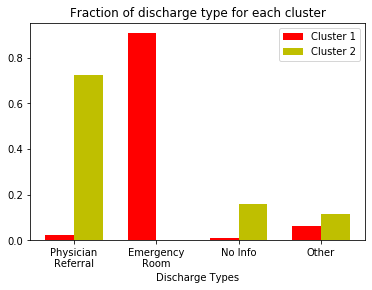

In [160]:
print(set(admission_type[0]))
N = 4

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, frac_admission_types[0], width, color='r')

rects2 = ax.bar(ind + width, frac_admission_types[1], width, color='y')

# add some text for labels, title and axes ticks
ax.set_title('Fraction of discharge type for each cluster')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Physician\nReferral', 'Emergency\nRoom', 'No Info', 'Other'))
ax.set_xlabel('Discharge Types')

ax.legend((rects1[0], rects2[0]), ('Cluster 1', 'Cluster 2'))


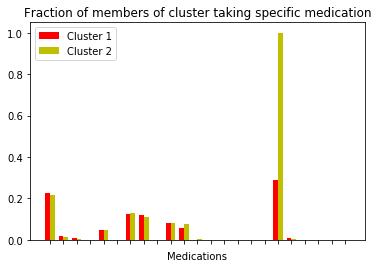

In [101]:
N = 23

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, meds_frac[0], width, color='r')

rects2 = ax.bar(ind + width, meds_frac[1], width, color='y')

# add some text for labels, title and axes ticks
ax.set_title('Fraction of members of cluster taking specific medication')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((''))
ax.set_xlabel('Medications')

ax.legend((rects1[0], rects2[0]), ('Cluster 1', 'Cluster 2'))


Text(0.5, 1.0, 'Histogram of Pairwise Edge Weights for Admission/Discharge Similarity Network')

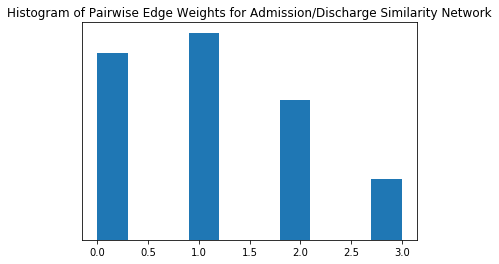

In [153]:
plt.hist(adj.flatten())
plt.yticks([])
plt.title('Histogram of Pairwise Edge Weights for Admission/Discharge Similarity Network')

([], <a list of 0 Text yticklabel objects>)

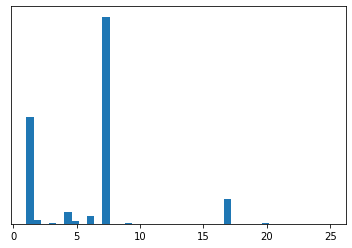

In [157]:
n = []
for i in data:
    n.append(i[8])
plt.hist(n, bins=40)
plt.yticks([])

In [ ]:
####

In [6]:
# Count number of patients with more than one hospital stay
patient_nums = {}
duplicate_count = 0
for i in data:
    if i[1] in patient_nums:
        patient_nums[i[1]] += 1
    else:
        patient_nums[i[1]] = 1
for i in patient_nums:
    if patient_nums[i] > 1:
        duplicate_count += 1
print(duplicate_count)

16773


In [7]:
# Count steady patients for each medication
num_medications = 24
ind = 24
ids = []
medications = [[] for i in range(num_medications)]
for i in data:
    ids.append(i[0])
    for j in range(num_medications):
        if i[j + ind] == 'Steady':
            medications[j].append(i[0])

In [8]:
# ids to indices
from_id = {}
for i in range(len(ids)):
    from_id[ids[i]] = i

In [9]:
patients = np.zeros((len(ids), len(ids)))
for i in medications:
    for j in range(len(i)):
        for k in range(j + 1, len(i)):
            patients[from_id[i[j]], from_id[i[k]]] += 1
            patients[from_id[i[k]], from_id[i[j]]] += 1

MemoryError: Unable to allocate array with shape (101766, 101766) and data type float64

In [10]:
# create network of medical specialties
meds = set()
for i in data:
    meds.add(i[11])
meds.remove('?')
nums_to_meds = list(meds)
meds_to_nums = {}
for ind, m in enumerate(nums_to_meds):
    meds_to_nums[m] = ind
num_meds = len(nums_to_meds)

In [11]:
adjacency = np.zeros((num_meds, num_meds))
counts = {}
for k in range(100000):
    ind = np.random.randint(0, len(data) - 1)
    i = data[ind]
    ind2 = np.random.randint(0, len(data) - 1)
    j = data[ind2]
    if (i[11] != '?') and (j[11] != '?') and (i[11] != j[11]):
        a = meds_to_nums[i[11]]
        b = meds_to_nums[j[11]]
        if i[2] == j[2]:
            adjacency[a, b] += 1
            adjacency[b, a] += 1
            if a in counts:
                counts[a] += 1
            else:
                counts[a] = 1
            if b in counts:
                counts[b] += 1
            else:
                counts[b] = 1
        if i[3] == j[3]:
            adjacency[a, b] += 1
            adjacency[b, a] += 1
            if a in counts:
                counts[a] += 1
            else:
                counts[a] = 1
            if b in counts:
                counts[b] += 1
            else:
                counts[b] = 1
adjacency /= np.mean(adjacency)

In [12]:
for i in range(len(adjacency)):
    try:
        adjacency[i,:] /= counts[i]
    except:
        pass
    try:
        adjacency[:,i] /= counts[i]
    except:
        pass

In [13]:
graph = nx.from_numpy_matrix(adjacency)

NameError: name 'nx' is not defined

In [14]:
# Eigenvector centrality
eigenvector = nx.eigenvector_centrality(graph)
e2 = []
for i in eigenvector:
    e2.append((i, eigenvector[i]))
e2.sort(key = lambda x: x[1], reverse = True)
for i in range(5):
    print(nums_to_meds[e2[i][0]])

NameError: name 'nx' is not defined

In [ ]:
def thread_func(start, end, adjacency):
    print('thread from ' + str(start) + ' to ' + str(end) + ' starting')
    for ind in range(start, end):
        for ind2 in range(ind + 1, len(data)):
            i = data[ind]
            j = data[ind2]
            if (i[11] != '?') and (j[11] != '?') and (i[11] != j[11]):
                a = meds_to_nums[i[11]]
                b = meds_to_nums[j[11]]
                if i[2] == j[2]:
                    adjacency[a, b] += 1
                    adjacency[b, a] += 1
                if i[3] == j[3]:
                    adjacency[a, b] += 1
                    adjacency[b, a] += 1
    print('thread from ' + str(start) + ' to ' + str(end) + ' finishing')
num_threads = 200
arrays = [np.zeros((num_meds, num_meds)) for i in range(num_threads)]
start = 0
end = int(len(data) / num_threads)
for i in range(num_threads):
    if i == (num_threads - 1):
        end = len(data)
    x = threading.Thread(target=thread_func, args=(start, end, arrays[i]))
    x.start()
    start = end
    end = start + int(len(data) / num_threads)

thread from 0 to 508 starting
thread from 508 to 1016 starting
thread from 1016 to 1524 starting
thread from 1524 to 2032 starting
thread from 2032 to 2540 starting
thread from 2540 to 3048 starting
thread from 3048 to 3556 starting
thread from 3556 to 4064 starting
thread from 4064 to 4572 starting
thread from 4572 to 5080 starting
thread from 5080 to 5588 starting
thread from 5588 to 6096 starting
thread from 6096 to 6604 starting
thread from 6604 to 7112 starting
thread from 7112 to 7620 starting
thread from 7620 to 8128 starting
thread from 8128 to 8636 starting
thread from 8636 to 9144 starting
thread from 9144 to 9652 starting
thread from 9652 to 10160 starting
thread from 10160 to 10668 starting
thread from 10668 to 11176 starting
thread from 11176 to 11684 starting
thread from 11684 to 12192 starting
thread from 12192 to 12700 starting
thread from 12700 to 13208 starting
thread from 13208 to 13716 starting
thread from 13716 to 14224 starting
thread from 14224 to 14732 starting
